## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
import corner
import glob
import re

import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
from scipy.stats import gaussian_kde
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
import gwpopulation as gwpop
from gwpopulation.models import mass, spin

xp = gwpop.cupy_utils.xp

### Functions 

Here, $q = \frac{m_2}{m_1}$

$$\chi_{\mathrm{eff}} = \frac{a_1 cost_1 + a_2 q cos t_2}{1 + q}$$

$$\chi_{\mathrm{p}} = max \bigg[a_1sint_1 , \bigg(\frac{4q + 3}{4 + 3q}\bigg)q a_2sint_2\bigg]$$


$$p_{LAL}(m_1, m_2, z) \propto (1+z)^2 D_L(z)^2  \bigg[ D_c(z) + \frac{c(1+z)}{H(z)}\bigg]$$

$$p_{astro}(m_1, m_2, z) \propto \frac{1}{(1+z)} (1+z)^{2.7} \frac{dV_c}{dz} m_1^{-2.2} q^{1.3}$$

To calculate $\frac{dV_c}{dz}$ :  https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

To calculate Hubble Parameter https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1*cost1 + a2*q*cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)


def H(z):
    omega_m = 0.3156                           #  Planck15.Om0         # 0.3156-used by tom     # unitless
    h_0 = Planck15.H(0).to('m/(Mpc*s)').value                           # m/Mpc/s
    h_z = h_0 * np.sqrt(omega_m * (1.0 + z)**3.0 + (1.0 - omega_m))   # m/Mpc-s
    return h_z
    
def LAL_prior(z, d_l):
    d_c = d_l/(1.0 + z)                                                        # Mpc
    c = astropy.constants.c.value                                              # m/s
    priorLAL = (1.0 + z)**2.0 * d_l**2.0 * (d_c + (c * (1.0 + z)/H(z)))
    return priorLAL

def astro_prior(m1, m2, z, d_l):
    
    # **Source frame** masses should be given as input (m1 and m2)
    
    alpha = -2.2
    beta = 1.3
    Mmin = 5.0
    Mmax = 75.0
    
    d_c = d_l/(1.0 + z)                                                        # Mpc
    c = astropy.constants.c.value                                              # m/s    
    dVc_dz = 4.0 * np.pi * c * (d_c**2.0) / H(z)
    
    pz = (1.0 + z)**1.7 * dVc_dz
    pm1 = m1**alpha
    pm2 = m2**beta / ((m1**(1.0 + beta)) - (Mmin**(1.0 + beta)))
    
    priorASTRO = pz*pm1*pm2
    priorASTRO[m2 < Mmin] = 0.0
    priorASTRO[m1 > Mmax] = 0.0
    
    return priorASTRO

Redshift Interpolant

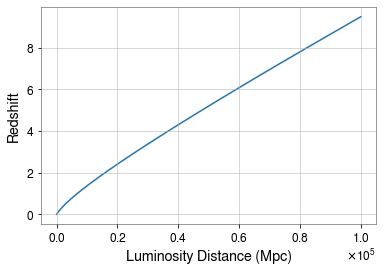

In [3]:
luminosity_distances = np.linspace(1, 100000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

In [ ]:
def draw_prior_samples(nsamps, q):
    
    m1_prior = 100.*np.ones(nsamps)
    m2_prior = q*m1_prior

    # Draw spin magnitudes and tilt angles
    a1_prior = np.random.random(nsamps)
    a2_prior = np.random.random(nsamps)
    cost1_prior = 2.*np.random.random(nsamps)-1
    cost2_prior = 2.*np.random.random(nsamps)-1

    # Compute and return effective spins
    xeff_prior = chieff(a1_prior,a2_prior,q,cost1_prior,cost2_prior)
    xp_prior = chiP(a1_prior,a2_prior,q,cost1_prior,cost2_prior)
    
    prior_samples = pd.DataFrame()
    prior_samples["m1"] = m1_prior
    prior_samples["m2"] = m2_prior
    prior_samples["a1"] = a1_prior
    prior_samples["a12"] = a2_prior
    prior_samples["cost1"] = cost1_prior
    prior_samples["cost2"] = cost2_prior
    prior_samples["chieff"] = xeff_prior
    prior_samples["chip"] = xp_prior
    
    return prior_samples

In [ ]:
prior_samples_01 = draw_prior_samples(1000000, 0.1)
prior_samples_05 = draw_prior_samples(1000000, 0.5)
prior_samples_10 = draw_prior_samples(1000000, 1.0)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
ax.hexbin(prior_samples_01["chieff"], prior_samples_01["chip"],cmap='Blues',gridsize=40)
ax = fig.add_subplot(132)
ax.hexbin(prior_samples_05["chieff"], prior_samples_05["chip"],cmap='Blues',gridsize=40)
ax = fig.add_subplot(133)
ax.hexbin(prior_samples_10["chieff"], prior_samples_10["chip"],cmap='Blues',gridsize=40)
plt.show()

In [ ]:
# Logistic transform:

def logistic(x):
    return 2.0/(1.0 + np.exp(-5.0*x))-1
    
x = np.linspace(-1,1)
plt.plot(x,logistic(x))
plt.show()

In [ ]:
def interpolants(prior_samples, demo = False):
    
    
    # Construct KDEs
    # 1D priors
    chi_eff_prior_kde = gaussian_kde(prior_samples["chieff"])
    chi_p_prior_kde = gaussian_kde(prior_samples["chip"])
    # 2D priors
    joint_prior_kde = gaussian_kde(np.array([logistic(prior_samples["chieff"]), prior_samples["chip"]]), 
                                   bw_method = 0.5 * prior_samples["chieff"].size**(-1.0/6.0))  # bw-method?
    
    
    # Construct chi_eff prior interpolant
    chi_eff_array = np.concatenate(([-1], np.arange(-0.99, 1.00, 0.01), [1]))
    prob_chi_eff_array = np.concatenate(([0.00], chi_eff_prior_kde(np.arange(-0.99, 1.00, 0.01)), [0]))
    chi_eff_norm = np.trapz(prob_chi_eff_array, chi_eff_array)
    chi_eff_interpolant = interp1d(chi_eff_array, prob_chi_eff_array/chi_eff_norm, kind = 'cubic')
    
    
    # Construct chi_p prior interpolant
    chi_p_array = np.concatenate(([0], np.arange(0.02, 1.00, 0.02), [0.99], [1]))
    prob_chi_p_array = np.concatenate(([0], chi_p_prior_kde(np.arange(0.02, 1.00, 0.02)), chi_p_prior_kde(0.99), [0]))
    chi_p_norm = np.trapz(prob_chi_p_array, chi_p_array)
    chi_p_interpolant = interp1d(chi_p_array, prob_chi_p_array/chi_p_norm, kind = 'cubic')
    
    
    # Construct XY grid for 2D joint prior spline
    x = np.concatenate([np.arange(-1.00, -0.20, 0.1), np.arange(-0.2, 0.2, 0.02), np.arange(0.2, 1.1, 0.1)])
    y = np.concatenate([[0.00], np.arange(0.02, 0.10, 0.01), np.arange(0.1,1.05,0.05)])
    X,Y = np.meshgrid(x, y)
    joint_prob = joint_prior_kde([X.reshape(-1), Y.reshape(-1)])
    joint_prob_2d = joint_prob.reshape(y.size, x.size)
    joint_prob_2d[0, :] = 0.00
    joint_prob_2d[-1, :] = 0.00
    joint_prob_2d[:, 0] = 0.00
    joint_prob_2d[:, -1] = 0.00
    joint_prior_spline = RectBivariateSpline(x, y, joint_prob_2d.T, kx = 2, ky =  2)
    
    if demo == True:
        return chi_eff_interpolant, chi_p_interpolant, joint_prior_spline, x, y, joint_prob_2d
    else: 
        return chi_eff_interpolant, chi_p_interpolant, joint_prior_spline
    

def evaluate_joint_prior(chi_eff_samples, chi_p_samples, joint_prior_spline):
    joint_priors_logistic_chieff = joint_prior_spline.ev(logistic(chi_eff_samples), chi_p_samples)
    joint_priors = joint_priors_logistic_chieff * (2.0*5.0*np.exp(-5.0*chi_eff_samples))/np.square(1.0 + np.exp(-5.0*chi_eff_samples))
    return joint_priors 

In [ ]:
prior_samples_08 = draw_prior_samples(1000000, 0.8)
chi_eff_interpolant, chi_p_interpolant, joint_prior_spline, demo_x, demo_y, demo_z = interpolants(
                                                                                    prior_samples_08, demo = True)

In [ ]:
# Plot chi-effective samples and interpolant
fig, ax = plt.subplots()
ax.hist(prior_samples_08["chieff"], bins=300, density=True)
ax.plot(np.linspace(-1.,1.,300),chi_eff_interpolant(np.linspace(-1.,1.,300)),color='black')
ax.set_xlabel('Chi-Effective',fontsize = 12)
plt.show()

# Plot chi-p samples and interpolant
fig, ax = plt.subplots()
n,bins,patches = ax.hist(prior_samples_08["chip"],bins=300,density=True)
ax.plot(np.linspace(0.,1.,300),chi_p_interpolant(np.linspace(0.,1.,300)),color='black')
ax.set_xlabel('Chi-p',fontsize=12)
plt.show()

# Our joint KDE and interpolant in logistic space
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121)
ax.hexbin(logistic(prior_samples_08["chieff"]),prior_samples_08["chip"],gridsize=30,cmap='Blues')
ax.set_xlabel('Logistic(Chi-Effective)',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('Samples',fontsize=12)

ax = fig.add_subplot(122)
ax.pcolormesh(demo_x,demo_y,demo_z)
ax.set_xlabel('Logistic(Chi-Effective)',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('KDE Grid',fontsize=12)

# Our joint prior moved back to chi-effective space
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121)
ax.hexbin(prior_samples_08["chieff"],prior_samples_08["chip"],gridsize=45,cmap='Blues')
ax.set_xlabel('Chi-Effective',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_title('Samples',fontsize=12)

ax = fig.add_subplot(122)
demo_grid_x = np.linspace(-1,1,1000)
demo_grid_y = np.linspace(0,1,1010)
X,Y = np.meshgrid(demo_grid_x,demo_grid_y)
demo_output = evaluate_joint_prior(X.reshape(-1),Y.reshape(-1),joint_prior_spline)
plt.pcolormesh(demo_grid_x,demo_grid_y,demo_output.reshape(demo_grid_y.size,demo_grid_x.size),cmap='Blues')
ax.set_xlabel('Chi-Effective',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('Spline Interpolant',fontsize=12)

plt.show()

In [ ]:
q_grid = np.linspace(0.01, 1.00, 40)
joint_prior_splines = []
chi_eff_prior_interps = []
chi_p_prior_interps = []

for q in q_grid:
    print(q)
    prior_samples = draw_prior_samples(1000000, q)
    chi_eff_interpolant, chi_p_interpolant, joint_prior_spline = interpolants(prior_samples)
    joint_prior_splines.append(joint_prior_spline)
    chi_eff_prior_interps.append(chi_eff_interpolant)
    chi_p_prior_interps.append(chi_p_interpolant)

In [ ]:
np.save("../processed_samples/priors.npy", np.array([q_grid, joint_prior_splines, 
                                                     chi_eff_prior_interps, chi_p_prior_interps]))

In [ ]:
q_grid, joint_prior_splines, chi_eff_prior_interps, chi_p_prior_interps = np.load(
    "../processed_samples/priors.npy", allow_pickle = True)

## Posteriors

#### GWTC - 1 

In [ ]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

posteriors = []
i = 0

file = '../../GWTC-1/GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', 
          '170729', '170809', '170814', '170818', '170823']

for event in events:
    print(i, event)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    

    _posterior['redshift'] = dl_to_z(_posterior['luminosity_distance'])
    _posterior['mass_1'] = _posterior['mass_1_det'] / (1.0 + _posterior['redshift'])
    _posterior['mass_2'] = _posterior['mass_2_det'] / (1.0 + _posterior['redshift'])
    _posterior['mass_ratio'] = _posterior['mass_2'] / _posterior['mass_1']
    _posterior['chi_eff'] = chieff(_posterior['a_1'], _posterior['a_2'], _posterior['mass_ratio'],
                                  _posterior['cos_tilt_1'], _posterior['cos_tilt_2'])
    _posterior['chi_p'] = chiP(_posterior['a_1'], _posterior['a_2'],
                              _posterior['mass_ratio'], _posterior['cos_tilt_1'], _posterior['cos_tilt_2'])
    del _posterior["mass_1_det"]
    del _posterior["mass_2_det"]

    nSamples = _posterior["chi_eff"].size

    joint_priors = np.zeros(nSamples)
    chi_eff_priors = np.zeros(nSamples)
    chi_p_priors = np.zeros(nSamples)

    for m in range(nSamples):
        ref_joint_prior_points = [evaluate_joint_prior(_posterior["chi_eff"][m], _posterior["chi_p"][m], spline) for spline in joint_prior_splines]
        joint = UnivariateSpline(q_grid, ref_joint_prior_points, k = 3, s = 0.1)
        joint_priors[m] = joint(_posterior["mass_ratio"][m])

        ref_chieff_prior_points = [interp(_posterior["chi_eff"][m]) for interp in chi_eff_prior_interps]
        chieff_1d = UnivariateSpline(q_grid, ref_chieff_prior_points, k = 3, s = 0.1)
        chi_eff_priors[m] = chieff_1d(_posterior["mass_ratio"][m])

        ref_chip_prior_points = [interp(_posterior["chi_p"][m]) for interp in chi_p_prior_interps]
        chip_1d = UnivariateSpline(q_grid, ref_chip_prior_points, k = 3, s = 0.1)
        chi_p_priors[m] = chip_1d(_posterior["mass_ratio"][m])

    # Mass priors

    prior_astro = astro_prior(_posterior["mass_1"],_posterior["mass_2"], _posterior["redshift"], _posterior["luminosity_distance"])
    prior_astro[prior_astro < 0] = 0
    prior_LAL = LAL_prior(_posterior["redshift"], _posterior["luminosity_distance"])
    weights = prior_astro/prior_LAL

    _posterior["joint_prior"] = joint_priors
    _posterior["chi_eff_prior"] = chi_eff_priors
    _posterior["chi_p_prior"] = chi_p_priors
    _posterior["weights"] = weights

    posteriors.append(_posterior)
    
    _posterior.to_csv("../processed_samples/OverallPosteriors/GW{}.csv".format(event), index = False)

#### GWTC - 2

In [ ]:
parameter_translator = dict(
    mass_1 = 'mass_1_source',
    mass_2 = 'mass_2_source',
    mass_ratio = 'mass_ratio',
    luminosity_distance = 'luminosity_distance',
    a_1 = 'a_1',
    a_2 = 'a_2',
    cos_tilt_1 = 'cos_tilt_1',
    cos_tilt_2 = 'cos_tilt_2', 
    chi_eff = 'chi_eff', 
    chi_p = 'chi_p', 
    redshift = 'redshift')

# 44 events excluding
# S190425z.h5
# S190426c.h5
# S190719an.h5
# S190814bv.h5
# S190909w.h5

events = ['S190408an.h5', 'S190412m.h5', 'S190413ac.h5', 
          'S190413i.h5', 'S190421ar.h5', 'S190424ao.h5', 
          'S190503bf.h5', 'S190512at.h5', 'S190513bm.h5',
          'S190514n.h5', 'S190517h.h5', 'S190519bj.h5',
          'S190521g.h5', 'S190521r.h5', 'S190527w.h5',
          'S190602aq.h5', 'S190620e.h5', 'S190630ag.h5',
          'S190701ah.h5', 'S190706ai.h5', 'S190707q.h5',
          'S190708ap.h5', 'S190720a.h5', 'S190727h.h5',
          'S190728q.h5', 'S190731aa.h5', 'S190803e.h5',
          'S190828j.h5', 'S190828l.h5', 'S190910s.h5', 
          'S190915ak.h5', 'S190924h.h5', 'S190929d.h5',
          'S190930s.h5']

file = '../../GWTC-2/GWTC-2_sample_release/{}'

for event in events:
    print(i, event)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["PrecessingSpinIMRHM"]['posterior_samples'][gwtc_key]

    nSamples = _posterior["chi_eff"].size

    joint_priors = np.zeros(nSamples)
    chi_eff_priors = np.zeros(nSamples)
    chi_p_priors = np.zeros(nSamples)

    for m in range(nSamples):
        ref_joint_prior_points = [evaluate_joint_prior(_posterior["chi_eff"][m], _posterior["chi_p"][m], 
                                                       spline) for spline in joint_prior_splines]
        joint = UnivariateSpline(q_grid, ref_joint_prior_points, k = 3, s = 0.1)
        joint_priors[m] = joint(_posterior["mass_ratio"][m])

        ref_chieff_prior_points = [interp(_posterior["chi_eff"][m]) for interp in chi_eff_prior_interps]
        chieff_1d = UnivariateSpline(q_grid, ref_chieff_prior_points, k = 3, s = 0.1)
        chi_eff_priors[m] = chieff_1d(_posterior["mass_ratio"][m])

        ref_chip_prior_points = [interp(_posterior["chi_p"][m]) for interp in chi_p_prior_interps]
        chip_1d = UnivariateSpline(q_grid, ref_chip_prior_points, k = 3, s = 0.1)
        chi_p_priors[m] = chip_1d(_posterior["mass_ratio"][m])

    # Mass priors

    prior_astro = astro_prior(_posterior["mass_1"],_posterior["mass_2"], _posterior["redshift"], 
                              _posterior["luminosity_distance"])
    prior_astro[prior_astro < 0] = 0
    prior_LAL = LAL_prior(_posterior["redshift"], _posterior["luminosity_distance"])
    weights = prior_astro/prior_LAL

    _posterior["joint_prior"] = joint_priors
    _posterior["chi_eff_prior"] = chi_eff_priors
    _posterior["chi_p_prior"] = chi_p_priors
    _posterior["weights"] = weights
    
    event = re.split('\/|\.',event)[-2]

    _posterior.to_csv("../processed_samples/OverallPosteriors/{}.csv".format(event), index = False)
    posteriors.append(_posterior)

In [ ]:
# To check that all 44 events have been processed

i = 0
for file in glob.glob("../processed_samples/OverallPosteriors/*"):
    filename = re.split('\/|\.',file)[-2]
    print(i, filename)
    i = i+1

In [4]:
## Only run this to load posteriors if they have already been calculated

posteriors = []

i = 0
for filename in glob.glob('../processed_samples/OverallPosteriors/*'):
    print(i, filename)
    i = i+1
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)

0 ../processed_samples/OverallPosteriors/S190408an.csv
1 ../processed_samples/OverallPosteriors/GW170823.csv
2 ../processed_samples/OverallPosteriors/S190521g.csv
3 ../processed_samples/OverallPosteriors/S190708ap.csv
4 ../processed_samples/OverallPosteriors/GW170818.csv
5 ../processed_samples/OverallPosteriors/S190521r.csv
6 ../processed_samples/OverallPosteriors/S190514n.csv
7 ../processed_samples/OverallPosteriors/S190513bm.csv
8 ../processed_samples/OverallPosteriors/S190929d.csv
9 ../processed_samples/OverallPosteriors/S190720a.csv
10 ../processed_samples/OverallPosteriors/S190620e.csv
11 ../processed_samples/OverallPosteriors/S190915ak.csv
12 ../processed_samples/OverallPosteriors/GW170809.csv
13 ../processed_samples/OverallPosteriors/S190803e.csv
14 ../processed_samples/OverallPosteriors/GW170608.csv
15 ../processed_samples/OverallPosteriors/S190512at.csv
16 ../processed_samples/OverallPosteriors/S190707q.csv
17 ../processed_samples/OverallPosteriors/GW150914.csv
18 ../processed

In [5]:
for posterior in posteriors:
    print(posterior["joint_prior"][posterior["joint_prior"] < 0])
    print(posterior["weights"][posterior["weights"] == 0])
#     posterior["joint_prior"][posterior["joint_prior"] < 0] = 0.
    posterior["prior"] = posterior["joint_prior"]/posterior["weights"]

Series([], Name: joint_prior, dtype: float64)
Series([], Name: weights, dtype: float64)
Series([], Name: joint_prior, dtype: float64)
Series([], Name: weights, dtype: float64)
Series([], Name: joint_prior, dtype: float64)
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
59461    0.0
59462    0.0
59463    0.0
59464    0.0
59465    0.0
Name: weights, Length: 55454, dtype: float64
Series([], Name: joint_prior, dtype: float64)
Series([], Name: weights, dtype: float64)
Series([], Name: joint_prior, dtype: float64)
Series([], Name: weights, dtype: float64)
Series([], Name: joint_prior, dtype: float64)
Series([], Name: weights, dtype: float64)
Series([], Name: joint_prior, dtype: float64)
370      0.0
801      0.0
922      0.0
1888     0.0
1968     0.0
        ... 
36792    0.0
36814    0.0
37120    0.0
38124    0.0
38134    0.0
Name: weights, Length: 69, dtype: float64
Series([], Name: joint_prior, dtype: float64)
Series([], Name: weights, dtype: float64)
Series(

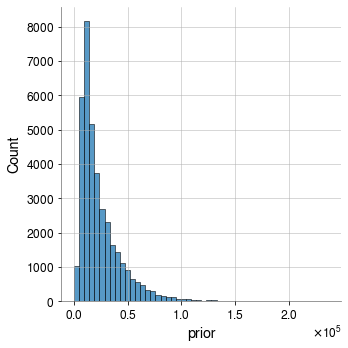

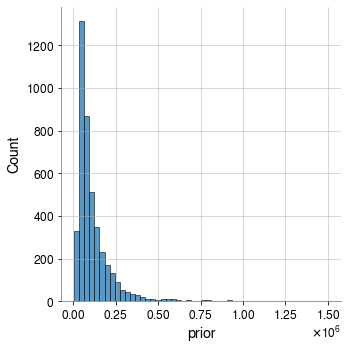

ValueError: autodetected range of [971.7967347470885, inf] is not finite

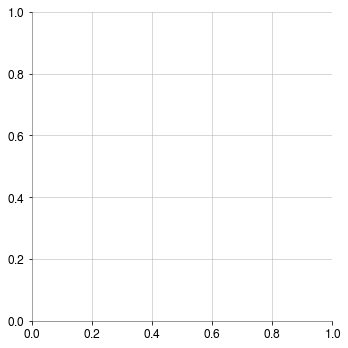

In [6]:
for posterior in posteriors:
    sns.displot(posterior["prior"], bins = 50)
    plt.show()

### Hyper-prior model

In [6]:
modelB = bilby.hyper.model.Model([spin.GaussianChiEffChiP()])

In [13]:
priorsB = PriorDict(dict(
    mu_chi_eff = Uniform(minimum = -1, maximum = 1, latex_label =r'$\mu_\mathrm{eff}$'),
    sigma_chi_eff = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_\mathrm{eff}$'), 
    mu_chi_p = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\mu_p$'),
    sigma_chi_p = Uniform(minimum = 0.01, maximum = 1, latex_label =r'$\sigma_p$'),
    spin_covariance = Uniform(minimum = -0.75, maximum = 0.75, latex_label =r'$\rho$')))

In [14]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors,
                                                     hyper_prior = modelB)

In [26]:
for ii in range(20):
    likelihoodB.parameters.update(priorsB.sample())
    print(likelihoodB.parameters)
    print(likelihoodB.log_likelihood_ratio())

{'mu_chi_eff': 0.14591871986722893, 'sigma_chi_eff': 0.3320093672507656, 'mu_chi_p': 0.9552663430047542, 'sigma_chi_p': 0.14837266035078364, 'spin_covariance': -0.6900007158964268}
-461.3039345613835
{'mu_chi_eff': -0.6358793435436014, 'sigma_chi_eff': 0.5086384972305419, 'mu_chi_p': 0.24300966291130346, 'sigma_chi_p': 0.5489156027319527, 'spin_covariance': -0.6514529676837302}
-483.7949229181446
{'mu_chi_eff': -0.7215638966084708, 'sigma_chi_eff': 0.9489511904191783, 'mu_chi_p': 0.9595016843766285, 'sigma_chi_p': 0.5030888029426926, 'spin_covariance': -0.6858201875989469}
-481.12831815734387
{'mu_chi_eff': -0.021951056590115536, 'sigma_chi_eff': 0.6880514987153907, 'mu_chi_p': 0.9740128533331046, 'sigma_chi_p': 0.6025655554665679, 'spin_covariance': 0.478071721000513}
-474.32324844794687
{'mu_chi_eff': -0.5231134513293514, 'sigma_chi_eff': 0.3337858253366471, 'mu_chi_p': 0.09874880848408092, 'sigma_chi_p': 0.9820097924826978, 'spin_covariance': 0.20050700906468033}
-471.3666573076138


In [27]:
likelihoodB.parameters.update(priorsB.sample())
likelihoodB.log_likelihood_ratio()

-479.5325880929662

In [28]:
resultB = bilby.run_sampler(likelihood = likelihoodB, priors = priorsB, sampler='dynesty', 
                            nlive = 1000, label = 'gaussian_no_vt', outdir = 'gaussian_no_vt', clean = True)

11:05 bilby INFO    : Running for label 'gaussian_no_vt', output will be saved to 'gaussian_no_vt'
11:05 bilby INFO    : Search parameters:
11:05 bilby INFO    :   mu_chi_eff = Uniform(minimum=-1, maximum=1, name=None, latex_label='$\\mu_\\mathrm{eff}$', unit=None, boundary=None)
11:05 bilby INFO    :   sigma_chi_eff = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_\\mathrm{eff}$', unit=None, boundary=None)
11:05 bilby INFO    :   mu_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\mu_p$', unit=None, boundary=None)
11:05 bilby INFO    :   sigma_chi_p = Uniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_p$', unit=None, boundary=None)
11:05 bilby INFO    :   spin_covariance = Uniform(minimum=-0.75, maximum=0.75, name=None, latex_label='$\\rho$', unit=None, boundary=None)
11:05 bilby INFO    : Single likelihood evaluation took 3.486e-03 s


0it [00:00, ?it/s]

11:05 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f5307156760>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:05 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:05 bilby INFO    : Using dynesty version 1.0.1
11:05 bilby INFO    : Using the bilby-implemented rwalk sam

12:24 bilby INFO    : Sampling time: 1:18:37.350518
12:24 bilby INFO    : Summary of results:
nsamples: 14011
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.129
ln_bayes_factor: -440.291 +/-  0.129



In [29]:
from matplotlib import rcParams

rcParams["text.usetex"] = True
rcParams["font.serif"] = "Computer Modern"
rcParams["font.family"] = "Serif"
rcParams["xtick.labelsize"]=14
rcParams["ytick.labelsize"]=14
rcParams["xtick.direction"]="in"
rcParams["ytick.direction"]="in"
rcParams["legend.fontsize"]=15
rcParams["axes.labelsize"]=16
rcParams["axes.grid"] = True
rcParams["grid.color"] = 'black'
rcParams["grid.linewidth"] = 1.
rcParams["grid.alpha"] = 0.6

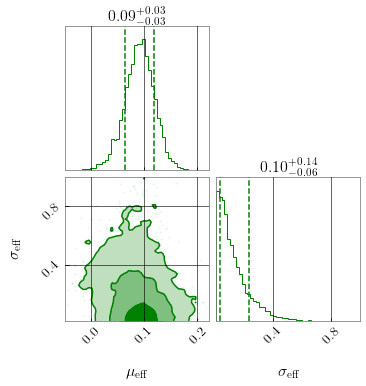

In [30]:
resultB.plot_corner(parameters = ("mu_chi_eff","sigma_chi_eff"), color = 'g')

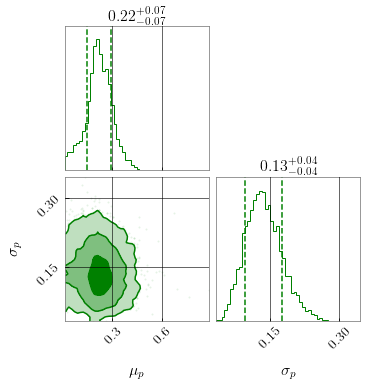

In [31]:
resultB.plot_corner(parameters = ("mu_chi_p","sigma_chi_p"), color = 'g')

### Post Processing

In [ ]:
result = bilby.core.result.read_in_result("q_grid/q_grid_result.json")

In [ ]:
resultB.posterior["log_likelihood"].max()